In [1]:
!pip install ipywidgets
!jupyter labextension install @jupyter-widgets/jupyterlab-manager


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.0/214.0 kB 22.8 MB/s eta 0:00:00
(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
Building jupyterlab assets (production, minimized)
/environment/miniconda3/lib/python3.11/site-packages/jupyterlab/debuglog.py:54: UserWarning: An error occurred.
  warnings.warn("An error occurred.")
/environment/miniconda3/lib/python3.11/site-packages/jupyterlab/debuglog.py:55: UserWarning: RuntimeError: npm dependencies failed to install
  warnings.warn(msg[-1

In [2]:
!pip install -U "openvino>=2025.0" "nncf>=2.15"
!pip install -q \
    "torch>=2.1" \
    "torchvision" \
    "gradio>=4.19" \
    "einops" \
    "transformers>=4.48.2" \
    "timm>=0.9.16" \
    "accelerate" \
    "sentencepiece" \
    "attrdict" \
    "mdtex2html" \
    "pypinyin" \
    "tiktoken" \
    "tqdm" \
    "colorama" \
    "Pygments" \
    "markdown" \
    --extra-index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 MB 66.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.6 MB/s eta 0:00:00:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 75.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 115.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 81.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 94.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301

In [3]:
# 1단계. 유틸리티 및 헬퍼 파일 다운로드

In [4]:
# 필요한 helper 파일 자동 다운로드
import requests
from pathlib import Path

# 공통 유틸
utility_files = ["cmd_helper.py", "notebook_utils.py", "pip_helper.py"]
base_utility_url = "https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/"

for utility in utility_files:
    if not Path(utility).exists():
        r = requests.get(base_utility_url + utility)
        with open(utility, "w", encoding="utf-8") as f:
            f.write(r.text)

# DeepSeek-VL2 전용 헬퍼
helper_files = ["ov_deepseek_vl_helper.py", "modeling_helper.py", "gradio_helper.py"]
base_helper_url = "https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/deepseek-vl2/"

for helper in helper_files:
    if not Path(helper).exists():
        r = requests.get(base_helper_url + helper)
        with open(helper, "w", encoding="utf-8") as f:
            f.write(r.text)


In [5]:
#2단계. 모델 준비 및 변환

In [14]:
# 모델 준비
from ov_deepseek_vl_helper import prepare_model_repo
prepare_model_repo()

# 변환에 필요한 설정
from ov_deepseek_vl_helper import model_ids, convert_deepseek_vl
from pathlib import Path
import nncf

model_id = "deepseek-ai/deepseek-vl2-tiny"  # 필요시 medium/large 등으로 변경 가능
quantization_config = {
    "vision": {"mode": nncf.CompressWeightsMode.INT8_ASYM},
    "llm": {
        "mode": nncf.CompressWeightsMode.INT4_SYM,
        "group_size": 64 if "tiny" in model_id else -1,
        "ratio": 1.0
    },
}

model_path = Path(model_id.split("/")[-1]) / "INT4"

# 모델 변환 및 압축
convert_deepseek_vl(model_id, model_path=model_path, quantization_config=quantization_config)


Applying Weight Compression ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 0:01:27 • 0:00:00

✅ Weights compression finished
✅ deepseek-ai/deepseek-vl2-tiny model conversion finished. You can find results in deepseek-vl2-tiny/INT4


PosixPath('deepseek-vl2-tiny/INT4')

In [15]:
#3단계. 추론 파이프라인 구성

In [16]:
from ov_deepseek_vl_helper import OVDeepseekVLV2ForCausalLM
from deepseek_vl2.models import DeepseekVLV2Processor
from notebook_utils import device_widget

# 장치 선택 (CPU 추천)
device = device_widget(default="CPU")
display(device)

# 모델 & 토크나이저 로딩
ov_model = OVDeepseekVLV2ForCausalLM(model_path, device.value)
processor = DeepseekVLV2Processor.from_pretrained(model_path)

Dropdown(description='Device:', options=('CPU', 'AUTO'), value='CPU')

Add pad token = ['<｜▁pad▁｜>'] to the tokenizer
<｜▁pad▁｜>:2
Add image token = ['<image>'] to the tokenizer
<image>:128815
Add grounding-related tokens = ['<|ref|>', '<|/ref|>', '<|det|>', '<|/det|>', '<|grounding|>'] to the tokenizer with input_ids
<|ref|>:128816
<|/ref|>:128817
<|det|>:128818
<|/det|>:128819
<|grounding|>:128820
Add chat tokens = ['<|User|>', '<|Assistant|>'] to the tokenizer with input_ids
<|User|>:128821
<|Assistant|>:128822



In [17]:
# 👀 ov_deepseek_vl_helper.py 파일 내용 확인
with open("ov_deepseek_vl_helper.py") as f:
    content = f.read()
    print("✅ parse_ref_bbox in file:", "parse_ref_bbox" in content)

✅ parse_ref_bbox in file: True


In [18]:
from ov_deepseek_vl_helper import OVDeepseekVLV2ForCausalLM
from deepseek_vl2.models import DeepseekVLV2Processor
from pathlib import Path

model_path = Path("deepseek-vl2-tiny/INT4")

ov_model = OVDeepseekVLV2ForCausalLM(model_path)
processor = DeepseekVLV2Processor.from_pretrained(model_path)


Add pad token = ['<｜▁pad▁｜>'] to the tokenizer
<｜▁pad▁｜>:2
Add image token = ['<image>'] to the tokenizer
<image>:128815
Add grounding-related tokens = ['<|ref|>', '<|/ref|>', '<|det|>', '<|/det|>', '<|grounding|>'] to the tokenizer with input_ids
<|ref|>:128816
<|/ref|>:128817
<|det|>:128818
<|/det|>:128819
<|grounding|>:128820
Add chat tokens = ['<|User|>', '<|Assistant|>'] to the tokenizer with input_ids
<|User|>:128821
<|Assistant|>:128822



In [19]:
#4단계. 이미지 기반 질의응답 테스트

In [20]:
# 강제 reload
import importlib
import ov_deepseek_vl_helper
importlib.reload(ov_deepseek_vl_helper)

# 다시 import
from ov_deepseek_vl_helper import parse_ref_bbox


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


The giraffe at the back.[[582, 270, 931, 906]]
🚀 추론 시간: 7.490초


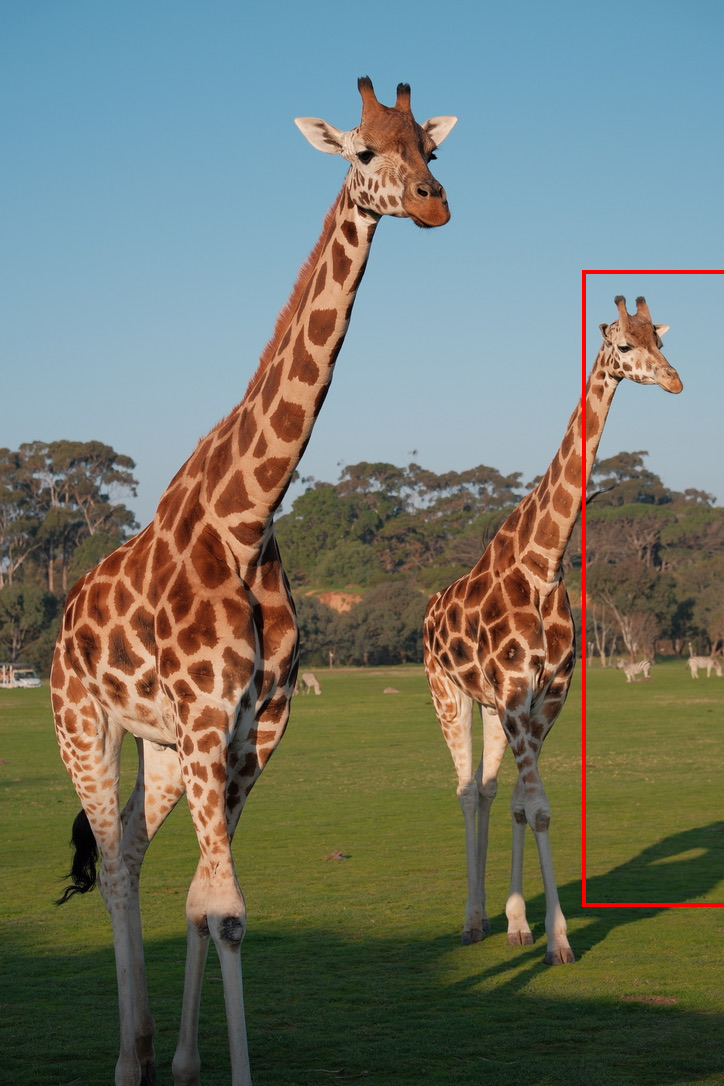

In [21]:
import time
from PIL import Image
from transformers import TextStreamer
from ov_deepseek_vl_helper import parse_ref_bbox

conversation = [
    {
        "role": "<|User|>",
        "content": "<image>\n<|ref|>The giraffe at the back.<|/ref|>",
        "images": ["DeepSeek-VL2/images/visual_grounding_1.jpeg"],
    },
    {"role": "<|Assistant|>", "content": ""},
]
# conversation = [
#     {
#         "role": "<|User|>",
#         "content": "<image>\n<|ref|>Please identify the giraffe at the back in the image. Describe its location clearly as if you were guiding a visually impaired person, like a navigation system.<|/ref|>",
#         "images": ["DeepSeek-VL2/images/visual_grounding_1.jpeg"],
#     },
#     {"role": "<|Assistant|>", "content": ""},
# ]

def load_pil_images(conversations):
    pil_images = []
    for message in conversations:
        if "images" not in message:
            continue
        for image_path in message["images"]:
            pil_img = Image.open(image_path).convert("RGB")
            pil_images.append(pil_img)
    return pil_images

pil_images = load_pil_images(conversation)


prepare_inputs = processor(conversations=conversation, images=pil_images, force_batchify=True, system_prompt="")
inputs_embeds = ov_model.prepare_inputs_embeds(**prepare_inputs)

#여기서 추론 시작하니까 시간 기록함
start_time = time.time()

outputs = ov_model.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs["attention_mask"],  # 경고 방지
    pad_token_id=processor.tokenizer.pad_token_id,
    bos_token_id=processor.tokenizer.bos_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True,
    streamer=TextStreamer(processor.tokenizer, skip_special_tokens=True),
)

#추론 끝날때 시간 기억해서 추론 시간 출력하ㅊ
end_time = time.time()
elapsed_time = end_time - start_time
print(f"🚀 추론 시간: {elapsed_time:.3f}초")


answer = processor.tokenizer.batch_decode(outputs, skip_special_tokens=False)
vg_image = parse_ref_bbox(answer[0], image=pil_images[-1])
if vg_image is not None:
    display(vg_image)


In [32]:
!pip install nltk seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TextStreamer
from ov_deepseek_vl_helper import OVDeepseekVLV2ForCausalLM
from deepseek_vl2.models import DeepseekVLV2Processor
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from PIL import Image

# 🌐 입력 문장 및 이미지
conversation = [{
    "role": "<|User|>",
    "content": "<image>\n<|ref|>Please identify the giraffe at the back in the image. Describe its location clearly as if you were guiding a visually impaired person, like a navigation system.<|/ref|>",
    "images": ["DeepSeek-VL2/images/visual_grounding_1.jpeg"],
}, {"role": "<|Assistant|>", "content": ""}]

def load_pil_images(conversations):
    pil_images = []
    for msg in conversations:
        if "images" in msg:
            for img in msg["images"]:
                pil_images.append(Image.open(img).convert("RGB"))
    return pil_images

pil_images = load_pil_images(conversation)

# === 1. OpenVINO 모델 ===
ov_model = OVDeepseekVLV2ForCausalLM(Path("deepseek-vl2-tiny/INT4"))
ov_processor = DeepseekVLV2Processor.from_pretrained("deepseek-vl2-tiny/INT4")
ov_inputs = ov_processor(conversations=conversation, images=pil_images, force_batchify=True, system_prompt="")

start_ov = time.time()
ov_embeds = ov_model.prepare_inputs_embeds(**ov_inputs)
ov_outputs = ov_model.language_model.generate(
    inputs_embeds=ov_embeds,
    attention_mask=ov_inputs["attention_mask"],
    pad_token_id=ov_processor.tokenizer.pad_token_id,
    eos_token_id=ov_processor.tokenizer.eos_token_id,
    bos_token_id=ov_processor.tokenizer.bos_token_id,
    max_new_tokens=512,
    do_sample=False,
    streamer=TextStreamer(ov_processor.tokenizer, skip_special_tokens=True),
)
end_ov = time.time()
ov_answer = ov_processor.tokenizer.batch_decode(ov_outputs, skip_special_tokens=True)[0]

# === 2. HuggingFace 모델 (CPU 강제)
hf_model = AutoModelForCausalLM.from_pretrained("deepseek-ai/deepseek-vl2", torch_dtype=torch.float32).to("cpu")
hf_tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/deepseek-vl2")
hf_inputs = hf_tokenizer(conversation[0]["content"].replace("<image>", ""), return_tensors="pt", padding=True).to("cpu")

start_hf = time.time()
hf_outputs = hf_model.generate(
    **hf_inputs,
    max_new_tokens=512,
    do_sample=False,
    streamer=TextStreamer(hf_tokenizer, skip_special_tokens=True),
)
end_hf = time.time()
hf_answer = hf_tokenizer.batch_decode(hf_outputs, skip_special_tokens=True)[0]

# === 3. 비교 분석 ===
print(f"🔷 HuggingFace 출력:\n{hf_answer}\n")
print(f"🔶 OpenVINO 출력:\n{ov_answer}\n")

bleu = sentence_bleu([hf_answer.split()], ov_answer.split())
print(f"🟢 BLEU Score: {bleu:.4f}")

def text_to_vec(text, tokenizer):
    tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids
    return tokens.float()

vec_hf = text_to_vec(hf_answer, hf_tokenizer).mean(dim=1).detach().numpy()
vec_ov = text_to_vec(ov_answer, hf_tokenizer).mean(dim=1).detach().numpy()
cos_sim = cosine_similarity(vec_hf.reshape(1, -1), vec_ov.reshape(1, -1))[0][0]
print(f"🔵 Cosine Similarity: {cos_sim:.4f}")

print(f"⏱️ HuggingFace 추론 시간: {end_hf - start_hf:.2f}초")
print(f"⏱️ OpenVINO 추론 시간: {end_ov - start_ov:.2f}초")

# === 4. 시각화 (BLEU / Cosine 비교)
plt.figure(figsize=(6, 5))
sns.barplot(x=["BLEU Score", "Cosine Similarity"], y=[bleu, cos_sim])
plt.ylim(0, 1)
plt.title("HuggingFace vs OpenVINO - Output Similarity")
plt.show()

# === 5. 시각화 (추론 속도 비교)
plt.figure(figsize=(6, 5))
sns.barplot(x=["PyTorch", "OpenVINO"], y=[end_hf - start_hf, end_ov - start_ov])
plt.ylabel("Latency (s)")
plt.title("Inference Latency Comparison")
plt.show()


Add pad token = ['<｜▁pad▁｜>'] to the tokenizer
<｜▁pad▁｜>:2
Add image token = ['<image>'] to the tokenizer
<image>:128815
Add grounding-related tokens = ['<|ref|>', '<|/ref|>', '<|det|>', '<|/det|>', '<|grounding|>'] to the tokenizer with input_ids
<|ref|>:128816
<|/ref|>:128817
<|det|>:128818
<|/det|>:128819
<|grounding|>:128820
Add chat tokens = ['<|User|>', '<|Assistant|>'] to the tokenizer with input_ids
<|User|>:128821
<|Assistant|>:128822



You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


The giraffe located behind the other giraffe is positioned slightly further away from the camera's viewpoint compared to the one in front. It stands near some trees and appears smaller due to perspective.


config.json:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/687k [00:00<?, ?B/s]

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

model-00001-of-000008.safetensors:   0%|          | 0.00/8.59G [00:00<?, ?B/s]

model-00007-of-000008.safetensors:   0%|          | 0.00/8.59G [00:00<?, ?B/s]

model-00008-of-000008.safetensors:   0%|          | 0.00/2.03G [00:00<?, ?B/s]

model-00004-of-000008.safetensors:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

model-00003-of-000008.safetensors:   0%|          | 0.00/8.59G [00:00<?, ?B/s]

model-00002-of-000008.safetensors:   0%|          | 0.00/8.59G [00:00<?, ?B/s]

model-00006-of-000008.safetensors:   0%|          | 0.00/8.59G [00:00<?, ?B/s]

model-00005-of-000008.safetensors:   0%|          | 0.00/8.60G [00:00<?, ?B/s]

In [ ]:
import time
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from transformers import TextStreamer
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer
from deepseek_vl2.models import DeepseekVLV2Processor, DeepseekVLV2ForCausalLM
from ov_deepseek_vl_helper import OVDeepseekVLV2ForCausalLM

# 1. 비교할 대화 입력
conversation = [{
    "role": "<|User|>",
    "content": "<image>\n<|ref|>Please identify the giraffe at the back in the image. Describe its location clearly as if you were guiding a visually impaired person, like a navigation system.<|/ref|>",
    "images": ["DeepSeek-VL2/images/visual_grounding_1.jpeg"],
}, {"role": "<|Assistant|>", "content": ""}]

# 2. 이미지 로딩 함수
def load_pil_images(conversations):
    pil_images = []
    for msg in conversations:
        if "images" in msg:
            for img in msg["images"]:
                pil_images.append(Image.open(img).convert("RGB"))
    return pil_images

pil_images = load_pil_images(conversation)

# 3. OpenVINO 모델
ov_model = OVDeepseekVLV2ForCausalLM(Path("deepseek-vl2-tiny/INT4"))
ov_processor = DeepseekVLV2Processor.from_pretrained("deepseek-vl2-tiny/INT4")
ov_inputs = ov_processor(conversations=conversation, images=pil_images, force_batchify=True, system_prompt="")

start_ov = time.time()
ov_embeds = ov_model.prepare_inputs_embeds(**ov_inputs)
ov_outputs = ov_model.language_model.generate(
    inputs_embeds=ov_embeds,
    attention_mask=ov_inputs["attention_mask"],
    pad_token_id=ov_processor.tokenizer.pad_token_id,
    eos_token_id=ov_processor.tokenizer.eos_token_id,
    bos_token_id=ov_processor.tokenizer.bos_token_id,
    max_new_tokens=512,
    do_sample=False,
    streamer=TextStreamer(ov_processor.tokenizer, skip_special_tokens=True),
)
end_ov = time.time()
ov_answer = ov_processor.tokenizer.batch_decode(ov_outputs, skip_special_tokens=True)[0]

# 4. PyTorch 원본 모델
torch_model = DeepseekVLV2ForCausalLM.from_pretrained("DeepSeek-VL2", torch_dtype=torch.float32).to("cpu")
torch_processor = DeepseekVLV2Processor.from_pretrained("DeepSeek-VL2")
torch_inputs = torch_processor(conversations=conversation, images=pil_images, force_batchify=True, system_prompt="")
torch_inputs = {k: v.to("cpu") if isinstance(v, torch.Tensor) else v for k, v in torch_inputs.items()}

start_torch = time.time()
torch_outputs = torch_model.generate(
    **torch_inputs,
    max_new_tokens=512,
    do_sample=False,
    streamer=TextStreamer(torch_processor.tokenizer, skip_special_tokens=True),
)
end_torch = time.time()
torch_answer = torch_processor.tokenizer.batch_decode(torch_outputs, skip_special_tokens=True)[0]

# 5. 출력 비교
print("🔷 PyTorch 응답:\n", torch_answer)
print("🔶 OpenVINO 응답:\n", ov_answer)

# 6. BLEU 및 Cosine Similarity
bleu_score = sentence_bleu([torch_answer.split()], ov_answer.split())
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/deepseek-vl2-tiny")

def get_embedding(text):
    tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    return tokens.input_ids.float().mean(dim=1).detach().numpy()

vec1 = get_embedding(torch_answer)
vec2 = get_embedding(ov_answer)
cos_sim = cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]

# 7. 결과 출력
print(f"\n🟢 BLEU Score: {bleu_score:.4f}")
print(f"🔵 Cosine Similarity: {cos_sim:.4f}")
print(f"⏱️ PyTorch 추론 시간: {end_torch - start_torch:.2f}초")
print(f"⏱️ OpenVINO 추론 시간: {end_ov - start_ov:.2f}초")

# 8. 시각화
plt.figure(figsize=(12, 5))

# 유사도 비교
plt.subplot(1, 2, 1)
sns.barplot(x=["BLEU Score", "Cosine Similarity"], y=[bleu_score, cos_sim])
plt.ylim(0, 1)
plt.title("Output Similarity")

# 추론 시간 비교
plt.subplot(1, 2, 2)
sns.barplot(x=["PyTorch", "OpenVINO"], y=[end_torch - start_torch, end_ov - start_ov])
plt.title("Inference Latency Comparison")
plt.ylabel("Latency (s)")

plt.tight_layout()
plt.show()
